In [1]:
import ChiantiPy
import ChiantiPy.core as ch
import ChiantiPy.tools.filters as chfilters
import ChiantiPy.tools.io as chio
import numpy as np
import atomic_species as at
import scipy.integrate as sp_int
import scipy.interpolate as sp_intpl
import matplotlib.pyplot as plt
import pandas as pd
import constants as const
import scipy.special as sp_special
import scipy.io as sp_io
import star_grid_new as sg
from copy import deepcopy
import functools as ft
from astropy.io import fits
import h5py
from flatstar import draw, utils

 ChiantiPy version 0.15.0 
 found PyQt5 widgets
 using PyQt5 widgets


In [2]:
#constants 

c = 2.9979e10
mp = 1.67e-24
k_b = 1.3807e-16
m_e = 9.11e-28
e = 4.803e-10
G = 6.67e-8

## Solar Spectrum

In [4]:
##turn .sav file of solar spectrum into usable python solar spectrum 
"""** Structure <20abc08>, 6 tags, length=165722064, data length=165722064, refs=1:
   WAVELENGTH      FLOAT     Array[920]			(nm)
   DATE_YD         DOUBLE    Array[14989]		(YYYYDOY date format)
   DATE_JD         DOUBLE    Array[14989]		(Julian Day format)
   IRRADIANCE      FLOAT     Array[14989, 920]	(mW/m^2/nm)
   FLAG_SOURCE     FLOAT     Array[14989, 920]	(number from -1 to 139 that represents data source)
   MODEL           FLOAT     Array[14989, 920]	(mW/m^2/nm)
   UNCERTAINTY_IRRADIANCE   FLOAT     Array[920]    (unitless, % relative accuracy)
   UNCERTAINTY_MODEL        FLOAT     Array[920]    (unitless, % relative accuracy)"""



ss_idl = sp_io.readsav('ssi3_ext_0nm_1600nm.sav')
ss_wav = ss_idl['ssi3_ext'][0][0] #nm
ss_irr = ss_idl['ssi3_ext'][0][3][:, 1000] #mw/m^2/nm
ss_mod = ss_idl['ssi3_ext'][0][5][:, 1000] #mw/m^2/nm

#turn into cgs
ss_wav_cgs = ss_wav * 1e-7
ss_irr_cgs = ss_irr * 1e7
ss_nu_cgs = c / ss_wav_cgs
ss_irr_nu_cgs = ss_irr_cgs * ss_wav_cgs**2 / c

ss = {'wl' : ss_wav_cgs, 'F_wl' : ss_irr_cgs, 'nu' : ss_nu_cgs, 'F_nu' : ss_irr_nu_cgs}

def normalize_spectrum(stellar_spectrum, Feuv, euv_range = [1e-6, 1.17e-5]):

    normalized_stellar_spectrum = deepcopy(stellar_spectrum)
    euv_mask = (stellar_spectrum['wl'] > euv_range[0]) & (stellar_spectrum['wl'] < euv_range[1])
    Feuv_ss = sp_int.trapezoid(stellar_spectrum['F_wl'][euv_mask], stellar_spectrum['wl'][euv_mask])
    normalized_stellar_spectrum['F_wl'] *= (Feuv / Feuv_ss)
    normalized_stellar_spectrum['F_nu'] *= (Feuv / Feuv_ss)
    
    return normalized_stellar_spectrum

norm_ss = normalize_spectrum(ss, 10**4)

In [9]:
ss['F_wl']

array([1.26756924e+04, 3.47264469e+05, 3.52401375e+05, 3.16926125e+05,
       3.92690125e+05, 5.66547500e+05, 1.34606838e+06, 1.05602312e+06,
       8.99943562e+05, 6.59016938e+05, 4.58933750e+05, 2.75939250e+05,
       1.69023672e+05, 1.58829375e+05, 3.60114156e+05, 4.12762094e+05,
       4.77086594e+05, 2.23950350e+06, 2.40634450e+06, 2.21950225e+06,
       1.84147675e+06, 1.38944612e+06, 1.26611000e+06, 6.55359750e+05,
       8.84120562e+05, 1.54378075e+06, 6.04299812e+05, 7.39690438e+05,
       1.44174638e+06, 2.67700938e+05, 6.05052000e+06, 3.63311250e+05,
       1.25437148e+05, 7.03854875e+05, 7.13175562e+05, 7.28908625e+05,
       1.10283675e+06, 2.44214969e+05, 1.15227500e+05, 7.66851406e+04,
       9.65135000e+04, 1.12438406e+05, 6.60103047e+04, 1.18787953e+05,
       8.58010938e+04, 7.99084531e+04, 1.88883969e+05, 9.87936953e+04,
       1.54869391e+05, 2.72854594e+05, 2.58187719e+05, 1.09408453e+05,
       1.33373156e+05, 8.89209297e+04, 6.29565391e+04, 2.73390531e+05,
      

In [4]:
#get star spectra from fits 

def get_spectra(fits_file):
    spec = fits.getdata(fits_file,1)
    wav = spec['WAVELENGTH'] * 1e-8       #in angstroms so turn into cgs 
    irr_wav = spec['FLUX'] * 1e8          
    nu = c / wav
    irr_nu = irr_wav * wav**2 / c
    return {'wl' : wav, 'F_wl': irr_wav, 'nu' : nu, 'F_nu' : irr_nu}

K6 = get_spectra('hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits')
K2 = get_spectra('hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_adapt-const-res-sed.fits')
G5 = get_spectra('hlsp_muscles_multi_multi_wasp-127_broadband_v24_adapt-const-res-sed.fits')
F4 = get_spectra('hlsp_muscles_multi_multi_wasp-43_broadband_v24_adapt-const-res-sed.fits')

norm_F4 = normalize_spectrum(F4, 10**5)

## Photoionization Equilibrium Solver

In [5]:
Zelem_lc = {'h':1, 'he':2, 'li':3, 'be':4, 'b':5, 'c':6, 'n':7,
              'o':8, 'f':9,'ne':10, 'na':11, 'mg':12, 'al':13,
              'si':14, 's':16, 'ar':18, 'ca':20, 'fe':26}

Aelem_lc = {'h':1,'he': 4,'li': 6,'be': 8,'b': 10,'c': 12,'n': 14,
              'o': 16,'f': 18,'ne': 20,'na': 22,'mg': 24,'al': 26,
              'si': 28,'s': 32,'ar': 36,'ca': 40,'fe': 52}


#get photoionization rates for atoms froms Verner.csv
def get_phion_rates(species, stellar_spectrum):
    #species in chianti format (need to change to McAstro format)
    Z = Zelem_lc[species]
    phion_rates = np.zeros(Z, 'float64')

    F_nu, nu = stellar_spectrum['F_nu'], stellar_spectrum['nu']

    for i in range(Z):
        ion = at.atomic_species(species.capitalize() + ' ' + at.arabic_to_roman(i+1))
        phion_rate = np.abs(sp_int.trapezoid(F_nu * ion.cross_section(nu * const.h * const.erg) / (const.h * nu), nu))
        phion_rates[i] = phion_rate

    return phion_rates

#get helium triplet state photoionization rate
def get_triplet_rate(stellar_spectrum):
    F_nu, nu = stellar_spectrum['F_nu'][::-1], stellar_spectrum['nu'][::-1]
    ss_intpl = sp_intpl.InterpolatedUnivariateSpline(nu, F_nu)
    data = pd.read_csv('HeMetastableData.csv', skiprows = 1)
    w = c / (data['wvl'].values * 1e-8)
    print(w)
    print(nu)
    print(data['wvl'])
    xs = sp_intpl.InterpolatedUnivariateSpline(w, data['sigma'].values * 8.067e-18)
    phion_rate = sp_int.quad(lambda nu : ss_intpl(nu) * xs(nu) / (const.h * nu), a = nu.values[0], b = nu.values[-1])
    return phion_rate[0]

#get recombination rate from chianti
def get_rr_rates(species, T):

    #get atomic Z of species
    Z = Zelem_lc[species]
    rr_rates = np.zeros(Z, 'float64')

    #loop through chianti to get recombination rates
    for i in range(Z):
        ion = ch.ion(f'{species}_{i + 2}', temperature = T, setup=0)
        ion.recombRate()
        rr_rates[i] = ion.RecombRate['rate'][0]

    return rr_rates

#photoionization solver hydrogen
xs_phot = 6.3e-18 

def get_nHI(nH, gamma, rr):
    nHI = nH * (1 + (gamma - np.sqrt(gamma**2 + 4 * rr * nH * gamma)) / (2 * rr * nH))
    return nHI

def get_ne(nH, gamma, rr):
    return nH - get_nHI(nH, gamma, rr)

def get_tau_phot(nH, gamma, rr, D):
    return nHI(nH, gamma, rr) * xs_phot * D

def get_nH(tau, gamma, rr, D):
    return tau / (D * xs_phot) + np.sqrt((tau * gamma) / (rr * D * xs_phot))


class HPhESolver:
    #class to calculate number hydrogen and protons
    def __init__(self, stellar_spectrum, nH):
        self.stellar_spectrum = stellar_spectrum
        self.nH = nH

    def calculate_abundances(self, T):
        phi_rate = get_phion_rates('h', self.stellar_spectrum)[0]
        rr_rate = get_rr_rates('h', T)[0]
        nHI = get_nHI(self.nH, phi_rate, rr_rate)
        nHII = get_ne(self.nH, phi_rate, rr_rate)
        return np.array([nHI, nHII]) / self.nH

#for all other elements, we assume that the electron number density is dominated by hydrogen ionization, so we assume all electrons from hydrogen 

#helium 

class HePhESolver:
    #class to calculate number of helium atoms in them singlet, triplet, singly ionized and doubly ionized states
    def __init__(self, stellar_spectrum, nHI, ne):
        self.stellar_spectrum = stellar_spectrum
        self.nHI = nHI
        self.ne = ne


    def calculate_abundances(self, T):
        #constants (note these are at 10^4K) 
        #NOTE: can put in temperature dependance 

        #electron/hydrogen collisional depopulation rates
        q13a = 4.5e-20 #cm^3s^-1
        q31a = 2.6e-8  #cm^3s^-1
        q31b = 4.0e-9  #cm^3s^-1
        Q31 = 5e-10    #cm^3s^-1
        A31 = 1.272e-4 #s^-1

        #photoionization rates
        phi1 = get_phion_rates('he', self.stellar_spectrum)[0]
        phi3 = get_phion_rates('he', self.stellar_spectrum)[0]
        phiHII = get_phion_rates('he', self.stellar_spectrum)[1]

        #recombination rates
        alpha1 = 2.10e-13   #use case A
        alpha3 = 2.10e-13 * (T / 10**4)**-0.778  #check recombination values
        alphaHIII = get_rr_rates('he', np.float64(T))[1]

        M = np.zeros((4, 4))
        M[0, :] = np.array([-self.ne * alpha1 - phi1 - q13a * self.ne, -self.ne * alpha1 + A31 + q31a * self.ne + q31b * self.ne + Q31 * self.nHI, 0, -self.ne * alpha1])
        M[1, :] = np.array([-self.ne * alpha3 + q13a * self.ne, -self.ne * alpha1 - phi3 - A31 - q31a * self.ne - q31b * self.ne - Q31 * self.nHI, 0, -self.ne * alpha3])
        M[2, :] = np.array([0, 0, phiHII, - alphaHIII * self.ne])
        M[3, :] = np.ones(4)

        o = np.array([-self.ne * alpha1, -self.ne * alpha3, 0, 1])

        abundances = np.linalg.solve(M, o)

        return abundances  

#all other elements

class PhESolver:
    #class to calculate 
    def __init__(self, species, stellar_spectrum, n_e):
        self.species = species #insert in chianti form
        self.stellar_spectrum = stellar_spectrum #if there's a stellar spectrum available
        self.n_e = n_e

    def getZ(self):
        return Zelem_lc[self.species]

    def calculate_abundances(self, T):
        Z = self.getZ()
        
        phi_rates = np.concatenate((get_phion_rates(self.species, self.stellar_spectrum), np.array([0.0])))
        rr_rates = get_rr_rates(self.species, np.float64(T))
        
        M = np.zeros((Z+1,Z+1))
        M[-1,:] = 1
        M += np.diag(phi_rates, 0) - np.diag(rr_rates, 1) * self.n_e
        
        o = np.zeros(Z+1)
        o[-1] = 1

        abundances = np.linalg.solve(M, o)

        return abundances

## xsection



In [35]:
def doppler_shift(w0, velocity):
    return (1 + velocity / c)*w0

def wav2v(wav, wav0):
    v = -c / wav0 * (wav - wav0)
    return v

def v2wav(v, wav0):
    wav = wav0 * (1 - v / c)
    return wav
    

def voigt_profile(w, w0, gauss_sigma, lorentz_HWHM, out=None, where=True):

    return sp_special.voigt_profile(w-w0, gauss_sigma, lorentz_HWHM, out=out, where=where)

    
def voigt_xsection(w, w0, f, Gamma, T, mmw, out=None, where=True):

    #w0 line centre of doppler shifted line
    
    lorentz_HWHM = Gamma / (4*np.pi)
    #fixed from last commit
    gauss_sigma = np.sqrt(k_b*T/(mmw * c**2))*w0
    xsection = np.pi * e**2 / (m_e * c) * f * voigt_profile(w, w0, gauss_sigma, lorentz_HWHM, out=out, where=where)
    return xsection

def voigt_xsection2(w, v, T, w0, f, Gamma, mmw):

    #w0 line centre at rest in vacuum 

    w0_ds = doppler_shift(w0, v)

    return voigt_xsection(w, w0_ds, f, Gamma, T, mmw)

    


def He_triplet_xsection(w, absorber_v, T, j):
    He_wavj0 = 1.082909e-4
    He_wavj1 = 1.083025e-4
    He_wavj2 = 1.083033e-4 #cm
    
    if j == 0:
        absorber_w0 = doppler_shift(c / He_wavj0, absorber_v) #in the frame of the object emitting light
        f = 5.9902e-02
        Gamma = 1.0216e+07
    elif j == 1:
        absorber_w0 = doppler_shift(c / He_wavj1, absorber_v)
        f = 1.7974e-01
        Gamma = 1.0216e+07
    elif j == 2:
        absorber_w0 = doppler_shift(c / He_wavj2, absorber_v)
        f = 2.9958e-01
        Gamma = 1.0216e+07

    xsection = voigt_xsection(w, absorber_w0, f, Gamma, T, 4*mp)
    return xsection

def He_triplet_xsection_combined(w, absorber_v, T):

    return He_triplet_xsection(w, absorber_v, T, 0) + He_triplet_xsection(w, absorber_v, T, 1) + He_triplet_xsection(w, absorber_v, T, 2)
    

def He_triplet_xsection_atlc(T):
    return He_triplet_xsection(c /  1.083033e-4, 0, T, 2) 


class xsection():
    #extract cross sections from Chianti or escape lines csv
    def __init__(self, species, species_base):
        self.species = species
        self.species_base = species_base

        #initialize escape lines 

    def getZ(self):
        return Zelem_lc[self.species_base]

    def getA(self):
        return Aelem_lc[self.species_base]

    def get_xs_species(self, w, absorber_v, T):
        all_lines = pd.read_csv('../escape_lines.csv')
        lines = all_lines[all_lines['species']==self.species]
        xs = np.zeros(np.shape(absorber_v)[:-1] + np.shape(w))

        for ix, row in lines.iterrows():
            w0 = doppler_shift(c / row['wavelength'], absorber_v)
            xs += voigt_xsection(w, w0, row['f'], row['A'], T, self.getA()*mp, out=out, where=where)
            
        return xs  

    def get_xs_lines(self, line_names, w, absorber_v, T, out=None, where=True):
        all_lines = pd.read_csv('../escape_lines.csv')
        lines = all_lines[all_lines['name'].isin(line_names)]
        xs = np.zeros(np.shape(absorber_v)[:-1] + np.shape(w))

        for ix, row in lines.iterrows():
            w0 = doppler_shift(c / row['wavelength'], absorber_v)
            xs += voigt_xsection(w, w0, row['f'], row['A'], T, self.getA()*mp, out=out, where=where)
            
        return xs  
        

    def topN_xs(self, T, N = 10):
        #based off top N f values so may be not be exactly true
        ion = ch.ion(self.species, temperature = np.float64(T), eDensity = 1.0)
        lv1 = np.array(ion.Wgfa['lvl1'])
        lv2 = np.array(ion.Wgfa['lvl2'])
        wvl = np.array(ion.Wgfa['wvl'])
        gf = np.array(ion.Wgfa['gf'])
        A = np.array(ion.Wgfa['avalue'])
        mult=np.array(ion.Elvlc['mult'])

        mask = (lv1 == 1) & (wvl != 0.0)
        ind = np.argsort(gf[mask])[::-1]
        wvl1 = np.abs(wvl[mask][ind]) * 1e-8 #change wavelength from angstom to cgs
        w  = c / wvl1   
        gf1 = gf[mask][ind] #gf is number of degenerate quantum states x oscillator strength
        A1 = A[mask][ind]
        lv1=lv1[mask][ind]
        mult=mult[lv1-1]
        f = gf1/mult
        

        if N < len(ind):
            return voigt_xsection(w[:N], w[:N], f[:N], A1[:N], T, self.getA() * mp), wvl1[:N] #check gf values here
        else:
            return voigt_xsection(w, w, gf1, A1, T, self.getA() * mp), wvl1

In [7]:
#make a datafile of interesting species

#Lyman Alpha, #He3, #He3(2), #CII, #CIII, #SiII, AlII, MgII, Mg, CaII, CaII(2), Ca, Na, K, FeII

#species
#transition name short
#transition name long, #species-lv1-lv2
#wavelength
#einstein A
#oscillator strength

a = pd.read_csv('../escape_lines.csv', dtype = {'species' : 'string'})
a['voigt'] = ft.partial(voigt_xsection2, (c / a['wavelength'], a['f'], a['A'], a['species'].str.partition('_')[0].map(AMelem_lc)))

## Torus 

In [30]:
class Torus:
    def __init__(self, species, stellar_spectrum, Mstar, Rstar, ap, T, Rtorus, i, tau=0, nH=0):
        self.species = species #dictionary of species with abundances relative to hydrogen 
        self.species_ion_abundances = {} #dictionary of ion abundances to be filled in 
        self.stellar_spectrum = stellar_spectrum
        self.Ms = Mstar 
        self.Rs = Rstar
        self.ap = ap
        self.T = T
        self.Rtorus = Rtorus
        self.D = self.Rtorus[1] - self.Rtorus[0]
        self.i = i
        
        #on initialization, we calculate the hydrogen state abundances. In order to do this, we need either a number density of hydrogen or a optical depth 
        gamma = get_phion_rates('h', self.stellar_spectrum)[0]
        rr_rate = get_rr_rates('h', T)[0]
        if tau:
            nH = get_nH(tau, gamma, rr_rate, self.D)
            self.tau = tau
            self.nH = nH
        elif nH:
            tau = get_tau_phot(nH, gamma, rr_rate, self.D)
            self.nH = nH
            self.tau = tau

        Hspecies_solver = HPhESolver(self.stellar_spectrum, self.nH)
        Hion_abundances = Hspecies_solver.calculate_abundances(self.T)
        self.species_ion_abundances['h'] = Hion_abundances
        #done
        
    #assume material rotates at keplerian velocity
    def omega_k(self, r):
        return np.sqrt(G * self.Ms / r**3)
    
    #make scale height 
    def get_H(self):
        cs = np.sqrt(2 * k_b * self.T / mp)
        disk_mid = (self.Rtorus[0] + self.Rtorus[1]) / 2
        H = np.sqrt(2 * cs**2 * disk_mid**3 / (G * self.Ms))
        return H
        
    def calculate_ion_abundances(self, single_species):

        if single_species in self.species_ion_abundances:
            return self.species_ion_abundances[single_species]
        elif single_species == 'he':
            he_species_solver = HePhESolver(self.stellar_spectrum, self.nH * self.species_ion_abundances['h'][0], self.nH * self.species_ion_abundances['h'][1])
            he_abundances = he_species_solver.calculate_abundances(self.T)
            self.species_ion_abundances[single_species] = he_abundances
            return he_abundances
        else:
            species_solver = PhESolver(single_species, self.stellar_spectrum, self.nH * self.species_ion_abundances['h'][1])
            ion_abundances = species_solver.calculate_abundances(self.T)
            self.species_ion_abundances[single_species] = ion_abundances
            return ion_abundances

    def calculate_ion_abundances_all_species(self):

        for sp in self.species:
            ion_abundances = self.calculate_ion_abundances(sp)
            self.species_ion_abundances[sp] = ion_abundances

    def calculate_column_density(self, species_state):
        if species_state == 'he_triplet':
            ncol = self.nH * self.species['he'] * self.species_ion_abundances['he'][1] * self.D
            return ncol
        species, ionic_state = species_state.partition('_')[0], int(species_state.partition('_')[2])
        if species in self.species_ion_abundances:
            ncol = self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state - 1] * self.D
            return ncol
        else:
            print("the ionic abundances for this species has not been calculated yet")
            
        
    def calculate_tau_species(self, species_state, nlines = 10):
        if species_state == 'he_triplet':
            tau = self.nH * self.species['he'] * self.species_ion_abundances['he'][1] * He_triplet_xsection_atlc(self.T) * self.D
            return tau
        species, ionic_state = species_state.partition('_')[0], int(species_state.partition('_')[2])
        if species in self.species_ion_abundances:
            species_xsection = xsection(species_state, species)
            xs, wvl = species_xsection.topN_xs(self.T, nlines)
            tau = self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state - 1] * xs * self.D
            return tau, wvl 
        else:
            print("the ionic abundances for this species has not been calculated yet")

    def do_transit_He(self): #this only works if the planet has an impact parameter of zero

        #specify star grid in which to perform ray tracing
        star_grid, areas_array = sg.make_grid_cartesian2(self.Rs, 10)
        xgrid = np.linspace(0.9*self.Rtorus[0], 1.1*self.Rtorus[1], 400) 
        dx = xgrid[1] - xgrid[0]
        wavgrid = np.linspace(1.0828e-4, 1.0833e-4, 400)
        wgrid = c / wavgrid

        #make dtau grid 
        y_mesh, x_mesh = np.meshgrid(star_grid[:, 0], xgrid, indexing = 'ij')
        z_mesh, x_mesh = np.meshgrid(star_grid[:, 1], xgrid, indexing = 'ij')
        Rgrid = np.sqrt(y_mesh**2 + x_mesh**2)
        ux_grid = self.omega_k(Rgrid) * y_mesh  
        dtau_grid = np.where(np.abs(z_mesh) < self.get_H(), np.where(((Rgrid > self.Rtorus[0]) & (Rgrid < self.Rtorus[1])), self.nH * self.species['he'] * self.species_ion_abundances['he'][1], 0), 0)[:, :, None] * He_triplet_xsection_combined(wgrid, np.reshape(ux_grid, (len(star_grid), len(xgrid), 1)), 10**4) * dx

        #turn into tau
        tau = np.sum(dtau_grid, axis = 1)

        #intensity
        intensity = np.einsum('i, ij -> j', areas_array, np.exp(-tau)) / (np.pi * self.Rs**2)

        return intensity

    def do_transit_He2(self, wavgrid): 

        #specify star grid in which to perform ray tracing
        star_grid, areas_array = sg.make_grid_cartesian2(self.Rs, 15)

        #xgrid extends out towards observer
        Rin_grid = self.Rtorus[0]*np.sin(self.i) - self.get_H()*np.cos(self.i)
        Rout_grid = self.Rtorus[1]*np.sin(self.i) + self.get_H()*np.cos(self.i)
        xgrid = np.linspace(0.9*Rin_grid, 1.1*Rout_grid, 50)  
        dx = xgrid[1] - xgrid[0]

        #wavgrid
        #wavgrid = np.linspace(1.0828e-4, 1.0833e-4, 400)
        wgrid = c / wavgrid
        
        #make dtau grid 
        y_mesh, x_mesh = np.meshgrid(star_grid[:, 0], xgrid, indexing = 'ij')
        z_mesh, x_mesh = np.meshgrid(star_grid[:, 1], xgrid, indexing = 'ij')

        yp_mesh = y_mesh
        zp_mesh = x_mesh * np.cos(self.i) + z_mesh * np.sin(self.i)
        xp_mesh = x_mesh * np.sin(self.i) - z_mesh * np.cos(self.i)
        
        
        Rgrid = np.sqrt(yp_mesh**2 + xp_mesh**2)
        ux_grid = self.omega_k(Rgrid) * y_mesh * np.sin(self.i)
        
        dtau_grid = np.where(np.abs(zp_mesh) < self.get_H(), np.where((Rgrid > self.Rtorus[0]) & (Rgrid < self.Rtorus[1]), self.nH * self.species['he'] * self.species_ion_abundances['he'][1], 0), 0)[:, :, None] * He_triplet_xsection_combined(wgrid, np.reshape(ux_grid, (len(star_grid), len(xgrid), 1)), 10**4) * dx

        #turn into tau
        tau = np.sum(dtau_grid, axis = 1)

        #intensity
        intensity = np.einsum('i, ij -> j', areas_array, np.exp(-tau)) / (np.pi * self.Rs**2)

        return intensity, tau

    def do_transit(self, species_state, lines, wavgrid):

        species, ionic_state = species_state.partition('_')[0], int(species_state.partition('_')[2])
        xs = xsection(species_state, species)
        
        #specify star grid in which to perform ray tracing
        star_grid, areas_array = sg.make_grid_cartesian2(self.Rs, 50)

        #xgrid extends out towards observer
        Rin_grid = self.Rtorus[0]*np.sin(self.i) - self.get_H()*np.cos(self.i)
        Rout_grid = self.Rtorus[1]*np.sin(self.i) + self.get_H()*np.cos(self.i)
        xgrid = np.linspace(0.9*Rin_grid, 1.1*Rout_grid, 50)  
        dx = xgrid[1] - xgrid[0]

        #wavgrid
        #wavgrid = wavgrid#np.linspace(1.0828e-4, 1.0833e-4, 400)
        wgrid = c / wavgrid
        
        #make dtau grid 
        y_mesh, x_mesh = np.meshgrid(star_grid[:, 0], xgrid, indexing = 'ij')
        z_mesh, x_mesh = np.meshgrid(star_grid[:, 1], xgrid, indexing = 'ij')

        yp_mesh = y_mesh
        zp_mesh = x_mesh * np.cos(self.i) + z_mesh * np.sin(self.i)
        xp_mesh = x_mesh * np.sin(self.i) - z_mesh * np.cos(self.i)
        
        Rgrid = np.sqrt(yp_mesh**2 + xp_mesh**2)
        ux_grid = self.omega_k(Rgrid) * yp_mesh * np.sin(self.i)
        
        dtau_grid = np.where(np.abs(zp_mesh) < self.get_H(), np.where((Rgrid > self.Rtorus[0]) & (Rgrid < self.Rtorus[1]), self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state-1], 0), 0)[:, :, None] * xs.get_xs_lines(lines, wgrid, np.reshape(ux_grid, (len(star_grid), len(xgrid), 1)), 10**4) * dx

        #turn into tau
        tau = np.sum(dtau_grid, axis = 1)
        

        #intensity
        intensity = np.einsum('i, ij -> j', areas_array, np.exp(-tau)) / (np.pi * self.Rs**2)

        return intensity, tau

    def do_transit2(self, species_state, lines, wavgrid):

        species, ionic_state = species_state.partition('_')[0], int(species_state.partition('_')[2])
        xs = xsection(species_state, species)

        #set up star grid
        grid_size = 35
        star_grid = draw.star(grid_size, supersampling=10)
        star_z = np.linspace(-self.Rs, self.Rs, grid_size)
        star_y = np.linspace(-self.Rs, self.Rs, grid_size)

        #xgrid extends out towards observer
        Rin_grid = self.Rtorus[0]*np.sin(self.i) - self.get_H()*np.cos(self.i)
        Rout_grid = self.Rtorus[1]*np.sin(self.i) + self.get_H()*np.cos(self.i)
        xgrid = np.linspace(0.9*Rin_grid, 1.1*Rout_grid, 50)  
        dx = xgrid[1] - xgrid[0]
        print(dx)

        #wavgrid
        wgrid = c / wavgrid

        #3D coordinate grid in observer frame
        star_z = np.linspace(-self.Rs, self.Rs, grid_size)
        xx, yy, zz = np.meshgrid(xgrid, star_y, star_z, indexing = 'ij')

        #coordinates in orbital plane of disk 
        yy_p = yy
        zz_p = xx * np.cos(self.i) + zz * np.sin(self.i)
        xx_p = xx * np.sin(self.i) - zz * np.cos(self.i)

        #cylindrical r coordinate
        R_p = np.sqrt(yy_p**2 + xx_p**2)

        #los velocity in observer frame
        ux = self.omega_k(R_p) * yy_p * np.sin(self.i)

        #evaluation grid
        dtau_eval_grid = np.tile(np.where(star_grid.intensity > 0, 1, 0), (np.shape(xgrid)[0], 1, 1)) #not on star
        dtau_eval_grid = np.where(np.abs(zz_p) < self.get_H(), 1, 0) #outside vertical extent of disk
        dtau_eval_grid = np.where((R_p > self.Rtorus[0]) & (R_p < self.Rtorus[1]), dtau_eval_grid, 0) #outside disk radial
        dtau_eval_grid = np.tile(np.expand_dims(dtau_eval_grid, axis=-1), len(wgrid)).astype(bool)

        #dtau grid
        
        dtau_grid = self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state-1] * xs.get_xs_lines(lines, wgrid, np.expand_dims(ux, axis=-1), self.T, where=dtau_eval_grid, out=np.zeros(np.shape(ux) + np.shape(wgrid))) * dx

        print(self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state-1])
        #optical depth
        tau = np.sum(dtau_grid, axis=0)

        #observed intensity
        intensity = np.einsum('ij, ijk -> k', star_grid.intensity, np.exp(-tau))
        
        return intensity, tau

        
    def get_EW(self):

        wavgrid = np.linspace(1.0828e-4, 1.0833e-4, 400)
        intensity = self.do_transit_He2()

        EW = sp_int.trapezoid(1 - intensity, wavgrid) / (1e-11)

        return EW

In [44]:
WASP12.species_ion_abundances

{'h': array([0.03797711, 0.96202289]),
 'he': array([3.17891725e-02, 4.59962046e-06, 6.57815221e-01, 3.10391007e-01]),
 'o': array([1.11276428e-03, 1.17719897e-01, 6.89676800e-01, 1.90748101e-01,
        7.40042924e-04, 2.39188930e-06, 2.80497932e-09, 5.65737243e-14,
        4.47566796e-23]),
 'mg': array([1.31467615e-01, 4.70945447e-01, 3.31474656e-01, 6.44133973e-02,
        1.68710398e-03, 1.17710204e-05, 9.49897002e-09, 1.22700205e-12,
        8.38997574e-17, 2.03990041e-21, 1.07923078e-26, 1.91999449e-35,
        2.69386828e-44]),
 'ca': array([ 3.96479740e-04,  2.04830016e-01,  5.07083894e-01,  2.72760234e-01,
         1.49050876e-02,  2.42846849e-05,  4.64806449e-09,  1.08300863e-12,
         6.99509809e-17,  9.02059803e-21,  3.35878533e-25,  5.45917809e-30,
         1.79703388e-35,  9.85967458e-41,  2.89106819e-46,  7.79435142e-56,
         1.03618229e-65,  1.06459855e-75,  1.33456214e-85, -0.00000000e+00,
        -0.00000000e+00])}

In [52]:
sum(WASP12.species[species] * (1 + sum(j * WASP12.species_ion_abundances[species][j] for j in range(len(WASP12.species_ion_abundances[species])))) for species in WASP12.species)   

2.2573825662193716

In [50]:
{values for species, values in WASP12.species.items()}

{1.5e-06, 3e-05, 0.001, 0.09, 1}

In [39]:
WASP12 = Torus({'h': 1, 'he' : 0.09, 'o' : 1e-3, 'mg' : 3e-5, 'ca': 1.5e-6}, norm_ss, 2.65e33, 1.66*7e10, 0.024*1.5e13, 1.0*10**4, [0.05*1.5e13, 0.06*1.5e13], np.pi/2, tau = 1)
WASP12.calculate_ion_abundances_all_species()
WASP12.species_ion_abundances



{'h': array([0.03797711, 0.96202289]),
 'he': array([3.17891725e-02, 4.59962046e-06, 6.57815221e-01, 3.10391007e-01]),
 'o': array([1.11276428e-03, 1.17719897e-01, 6.89676800e-01, 1.90748101e-01,
        7.40042924e-04, 2.39188930e-06, 2.80497932e-09, 5.65737243e-14,
        4.47566796e-23]),
 'mg': array([1.31467615e-01, 4.70945447e-01, 3.31474656e-01, 6.44133973e-02,
        1.68710398e-03, 1.17710204e-05, 9.49897002e-09, 1.22700205e-12,
        8.38997574e-17, 2.03990041e-21, 1.07923078e-26, 1.91999449e-35,
        2.69386828e-44]),
 'ca': array([ 3.96479740e-04,  2.04830016e-01,  5.07083894e-01,  2.72760234e-01,
         1.49050876e-02,  2.42846849e-05,  4.64806449e-09,  1.08300863e-12,
         6.99509809e-17,  9.02059803e-21,  3.35878533e-25,  5.45917809e-30,
         1.79703388e-35,  9.85967458e-41,  2.89106819e-46,  7.79435142e-56,
         1.03618229e-65,  1.06459855e-75,  1.33456214e-85, -0.00000000e+00,
        -0.00000000e+00])}

In [32]:
WASP12.nH / 1e8

0.2786417847311798

In [33]:
#calculate optical depth at linecenter

tau_mg_lc = WASP12.calculate_tau_species('mg_2')
print(tau_mg_lc)

#tau_ca_lc = WASP12.calculate_tau_species('ca_2')
#print(tau_ca_lc)

#tau_he_lc = WASP12.calculate_tau_species('he_triplet')
#print(tau_he_lc)





(array([5.98049133e+01, 2.98851470e+01, 5.95397441e-01, 5.58735504e-01,
       5.34600438e-01, 5.76236271e-01, 2.81529762e-01, 1.36549226e-01,
       7.35222057e-02, 4.87136145e-02]), array([2.796350e-05, 2.803531e-05, 1.995180e-06, 1.995080e-06,
       1.998070e-06, 2.483900e-06, 2.472100e-06, 2.090930e-06,
       2.094290e-06, 1.885300e-06]))


In [37]:
i_mg2

array([0.99985269, 0.99983667, 0.99981773, 0.99979507, 0.99976761,
       0.99973376, 0.9996912 , 0.99963635, 0.99956334, 0.99946176,
       0.99931061, 0.99893968, 0.99118062, 0.9601695 , 0.91558472,
       0.86559234, 0.80668105, 0.74907271, 0.71623938, 0.70534747,
       0.70610765, 0.71058094, 0.71305791, 0.71304652, 0.71040545,
       0.7059355 , 0.70626791, 0.71929038, 0.75554274, 0.81433298,
       0.87239725, 0.92173981, 0.96494477, 0.99328112, 0.99902842,
       0.9993326 , 0.99947595, 0.99957326, 0.99964365, 0.99969675,
       0.99973809, 0.99977106, 0.99979786, 0.99982001, 0.99983856,
       0.99985427, 0.99986771, 0.99987932, 0.99988941, 0.99989825])

In [53]:


#i_mg, tau_mg = WASP12.do_transit('mg_2', ['mg2_h', 'mg2_k'], np.linspace(2.7958e-5, 2.7970e-5, 50))
i_mg2, tau_mg2 = WASP12.do_transit2('mg_2', ['mg2_h', 'mg2_k'], np.linspace(2.7958e-5, 2.7970e-5, 50))


#i_ca, tau_ca = WASP12.do_transit('ca_2', ['ca2_h', 'ca2_k'], np.linspace(3.9340e-5, 3.9355e-5, 50))
i_he, tau_he = WASP12.do_transit_He2(np.linspace(1.0828e-4, 1.0833e-4, 50))

6428571428.571411
393.6752398590086


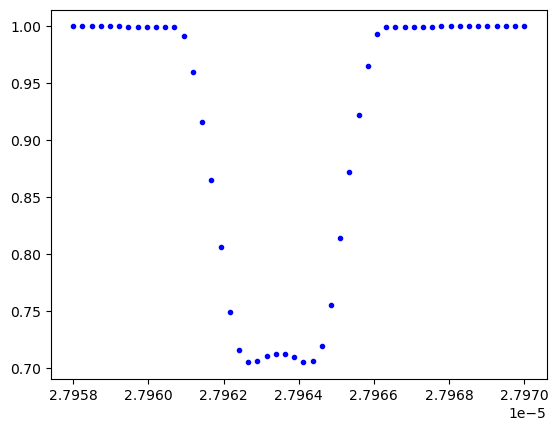

/var/folders/3z/jz_8jm5j13b896ydcgw7m65c0000gn/T/ipykernel_85077/1635776623.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


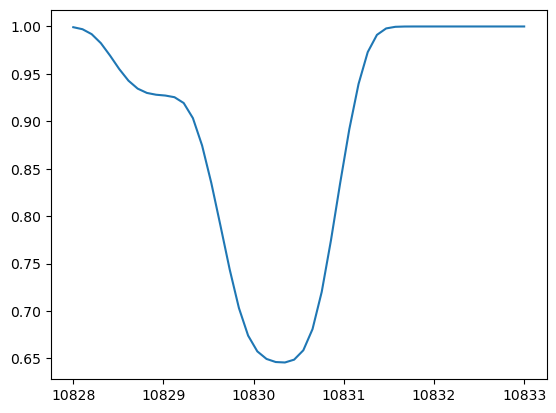

In [54]:
#magnesium

fig1, ax1 = plt.subplots()
wav0 = 2.79635e-5
ax1.plot(np.linspace(2.7958e-5, 2.7970e-5, 50), i_mg2, 'b.')
#secax1=ax1.secondary_xaxis('top', functions=(fc.partial(wav2v, wav0), fc.partial(v2wav, wav0))) 
plt.show()

#fig1, ax1 = plt.subplots()
#wav0 = 2.79635e-5
#ax1.plot(np.linspace(2.7958e-5, 2.7970e-5, 50), i_mg, 'b.')
#secax1=ax1.secondary_xaxis('top', functions=(fc.partial(wav2v, wav0), fc.partial(v2wav, wav0))) 
#plt.show()

#calcium

"""fig2, ax2 = plt.subplots()
wav0 = 3.934777e-05
ax2.plot(np.linspace(3.9340e-5, 3.9355e-5, 50), i_ca)
#secax2=ax2.secondary_xaxis('top', functions=(fc.partial(wav2v, wav0), fc.partial(v2wav, wav0))) 
fig2.show()
"""

#helium
fig3, ax3 = plt.subplots()
wav0 = (10830.34*0.3 + 10830.25*0.18) / 0.48
wavgrid = np.linspace(1.0828e-4, 1.0833e-4, 50) * 1e8
ax3.plot(wavgrid, i_he)
#secax3=ax3.secondary_xaxis('top', functions=(fc.partial(wav2v, wav0), fc.partial(v2wav, wav0))) 
fig3.show()




In [20]:
i_mg2

array([0.99985269, 0.99983667, 0.99981773, 0.99979507, 0.99976761,
       0.99973376, 0.9996912 , 0.99963635, 0.99956334, 0.99946176,
       0.99931061, 0.99893968, 0.99118062, 0.9601695 , 0.91558472,
       0.86559234, 0.80668105, 0.74907271, 0.71623938, 0.70534747,
       0.70610765, 0.71058094, 0.71305791, 0.71304652, 0.71040545,
       0.7059355 , 0.70626791, 0.71929038, 0.75554274, 0.81433298,
       0.87239725, 0.92173981, 0.96494477, 0.99328112, 0.99902842,
       0.9993326 , 0.99947595, 0.99957326, 0.99964365, 0.99969675,
       0.99973809, 0.99977106, 0.99979786, 0.99982001, 0.99983856,
       0.99985427, 0.99986771, 0.99987932, 0.99988941, 0.99989825])

In [189]:
i_mg - i_mg2

array([-1.71906644e-06, -1.74489317e-06, -1.73371380e-06, -1.66113179e-06,
       -1.48672502e-06, -1.14147328e-06, -5.02784814e-07,  6.58742279e-07,
        2.80396308e-06,  6.95850394e-06,  1.59788286e-05,  1.14155833e-04,
        3.72980730e-03,  8.42637458e-03,  9.78671006e-03,  1.01845788e-02,
        8.54472920e-03,  3.06749153e-03, -7.28319363e-03, -1.36825824e-02,
       -1.80212300e-02, -2.02824624e-02, -2.03065020e-02, -2.03583865e-02,
       -1.99820279e-02, -1.76919862e-02, -1.35664478e-02, -7.56180731e-03,
        1.81794173e-03,  6.29316528e-03,  8.18456422e-03,  7.79105483e-03,
        6.82253951e-03,  2.65073632e-03,  6.80233853e-05,  8.69517071e-06,
        2.42639231e-06, -3.17433124e-07, -1.61602211e-06, -2.22789001e-06,
       -2.48951358e-06, -2.56519645e-06, -2.54055394e-06, -2.46227122e-06,
       -2.35661136e-06, -2.23863653e-06, -2.11705190e-06, -1.99685999e-06,
       -1.88086557e-06, -1.77055301e-06])

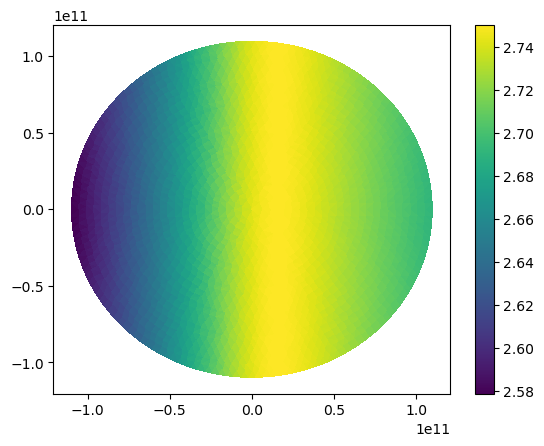

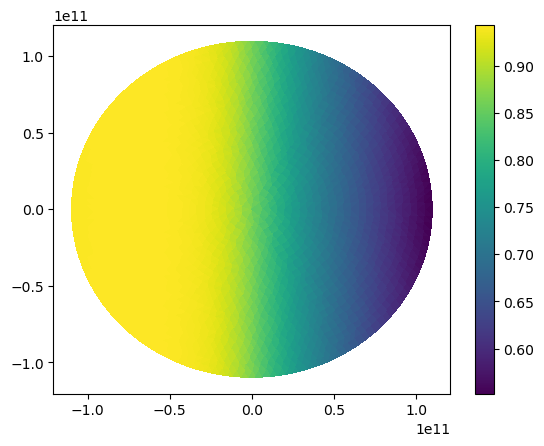

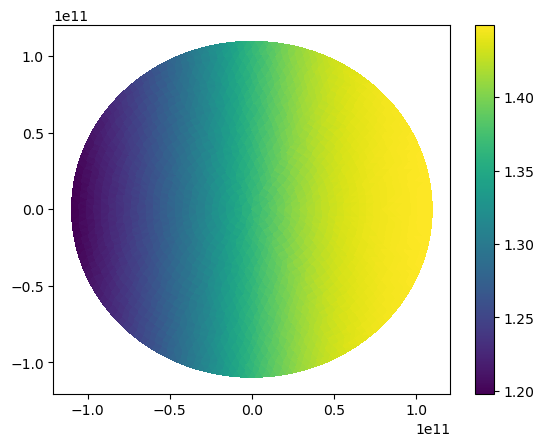

In [1133]:
#examine optical depths
fig1, ax1 = plt.subplots()
im1 = ax1.tripcolor(star_grid[:, 0], star_grid[:, 1], np.log10(tau_mg[:, 135]))
fig1.colorbar(im1, ax=ax1)

fig2, ax2 = plt.subplots()
im2 = ax2.tripcolor(star_grid[:, 0], star_grid[:, 1], np.log10(tau_ca[:, 160]))
fig1.colorbar(im2, ax=ax2)

fig3, ax3 = plt.subplots()
im3 = ax3.tripcolor(star_grid[:, 0], star_grid[:, 1], np.log10(tau_he[:, 170]))
fig3.colorbar(im3, ax=ax3)



In [1110]:
tau_mg

array([[3.64571773e+01, 2.55013831e+01],
       [3.99611535e+01, 2.97852215e+01],
       [4.54908809e+01, 3.98934241e+01],
       ...,
       [7.03116898e-04, 6.50207312e-04],
       [6.99668864e-04, 6.47145175e-04],
       [4.58129693e+01, 4.21528196e+01]])

In [832]:
star_grid, areas_array = sg.make_grid_cartesian2(WASP12.Rs, 10)
xgrid = np.linspace(0.9*WASP12.Rtorus[0], 1.1*WASP12.Rtorus[1], 400) 
dx = xgrid[1] - xgrid[0]
wavgrid = np.linspace(1.0828e-4, 1.0833e-4, 400)
wgrid = c / wavgrid

#make dtau grid 
y_mesh, x_mesh = np.meshgrid(star_grid[:, 0], xgrid, indexing = 'ij')
z_mesh, x_mesh = np.meshgrid(star_grid[:, 1], xgrid, indexing = 'ij')
Rgrid = np.sqrt(y_mesh**2 + x_mesh**2)
ux_grid = WASP12.omega_k(Rgrid) * y_mesh
dtau_grid = np.where(np.abs(z_mesh) < WASP12.get_H(), np.where(((Rgrid > WASP12.Rtorus[0]) & (Rgrid < WASP12.Rtorus[1])), WASP12.nH * WASP12.species['he'] * WASP12.species_ion_abundances['he'][1], 0), 0)[:, :, None] * He_triplet_xsection_combined(wgrid, np.reshape(ux_grid, (len(star_grid), len(xgrid), 1)), 10**6) * dx

In [949]:
WASP12 = Torus({'h': 1, 'he' : 0.11, 'mg' : 1e-4}, norm_ss, 2.65e33, 1.6*7e10, 0.02*1.5e13, 10**4, [0.04*1.5e13, 0.06*1.5e13], np.pi/2, tau = 1)
WASP12.calculate_ion_abundances_all_species()
#intensity = WASP12.do_transit_He2()


0.011389672756195068


In [849]:
WASP12.species_ion_abundances

{'h': array([0.00873617, 0.99126383]),
 'he': array([3.64260647e-03, 2.40173337e-06, 3.20697880e-01, 6.75657112e-01]),
 'mg': array([8.61056754e-03, 1.37723705e-01, 4.32826144e-01, 3.75547162e-01,
        4.39192787e-02, 1.36820922e-03, 4.92992153e-06, 2.84337309e-09,
        8.68109078e-13, 9.42426787e-17, 2.22627098e-21, 1.76843366e-29,
        1.10787369e-37])}

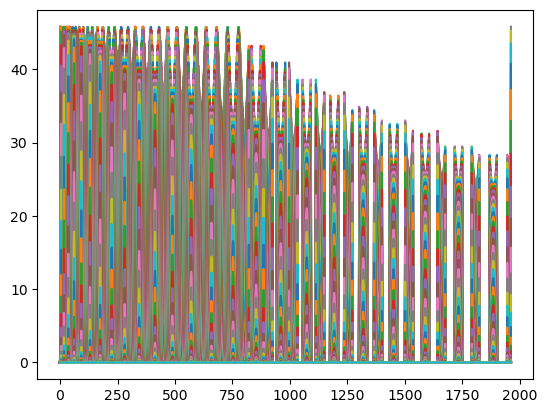

In [1057]:
plt.plot(tau_mg);

In [988]:
i, tau = WASP12.do_transit('mg_2', ['mg2_h', 'mg2_k'], np.linspace(2.7955e-5, 2.7970e-5, 500))

(1962, 400, 500)


In [907]:
np.shape(tau)

(1255, 500)

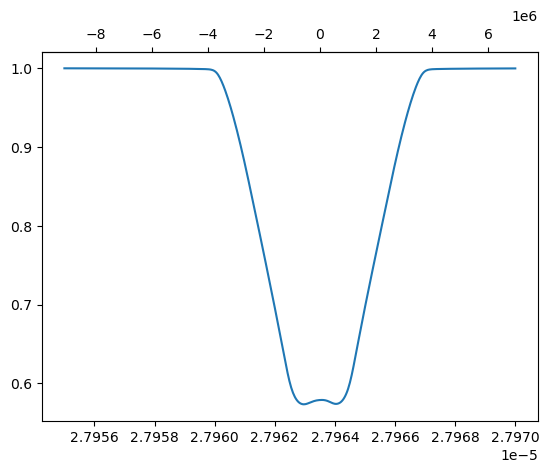

In [989]:
fig, ax = plt.subplots()
wav0 = 2.79635e-5


ax.plot(np.linspace(2.7955e-5, 2.7970e-5, 500), i)
secax=ax.secondary_xaxis('top', functions=(fc.partial(wav2v, wav0), fc.partial(v2wav, wav0))) 

In [970]:
wav0

2.79635e-05

In [966]:
ll = fc.partial(v2wav, w0)

In [967]:
ll(0)

0.0

In [ ]:
#plot optical depth 

In [696]:
xs_mg2 = xsection('mg2', 'mg')
#xs_mg2.get_xs_lines(['mg2_h'], 2.79635e-05, 0, 10**4)


WASP12.nH * WASP12.species['mg'] * WASP12.species_ion_abundances['mg'][1] * WASP12.D * xs_mg2.get_xs_lines(['mg2_h'], np.ones((2,2)) * 2.79635e-05, np.ones((2,2))*1e6, 10**4)

(2, 2, 2)


array([[[2.34717685e-12, 2.34717685e-12],
        [2.34717685e-12, 2.34717685e-12]],

       [[2.34717685e-12, 2.34717685e-12],
        [2.34717685e-12, 2.34717685e-12]]])

In [678]:
WASP12.calculate_tau_species('mg_2')

(array([5.06856215e+01, 2.53281406e+01, 5.04608863e-01, 4.73537285e-01,
        4.53082430e-01, 4.88369465e-01, 2.38600981e-01, 1.15727655e-01,
        6.23112464e-02, 4.12855682e-02]),
 array([2.796350e-05, 2.803531e-05, 1.995180e-06, 1.995080e-06,
        1.998070e-06, 2.483900e-06, 2.472100e-06, 2.090930e-06,
        2.094290e-06, 1.885300e-06]))

In [511]:
WASP12.species_ion_abundances

{'h': array([0.00975727, 0.99024273]),
 'he': array([4.38364489e-03, 2.58532535e-06, 3.45170758e-01, 6.50443012e-01]),
 'ca': array([ 1.31738792e-05,  2.71804300e-02,  2.68727805e-01,  5.77276541e-01,
         1.25981685e-01,  8.19738502e-04,  6.26592400e-07,  5.83062368e-10,
         1.50399690e-13,  7.74566032e-17,  1.15179562e-20,  7.47636585e-25,
         9.82855406e-30,  2.15360462e-34,  2.52192283e-39,  2.71533549e-48,
         1.44161641e-57,  5.91520063e-67,  2.96136879e-76, -0.00000000e+00,
        -0.00000000e+00])}

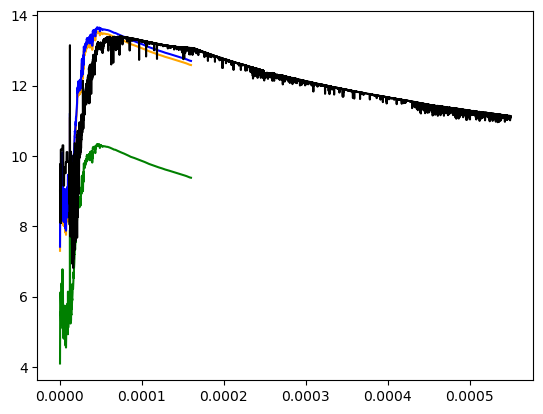

In [1150]:
plt.plot(ss['wl'], np.log10(ss['F_wl']), 'g')
plt.plot(ss['wl'], np.log10(ss['F_wl']*(1 / 0.025)**2), 'orange')
plt.plot(norm_ss['wl'], np.log10(norm_ss['F_wl']), 'blue')
plt.plot(norm_F4['wl'], np.log10(norm_F4['F_wl']), 'black')

In [ ]:
ss

In [97]:
intensity = WASP12.do_transit_He()
intensity2 = WASP12.do_transit_He2()

In [529]:
testTorus = Torus({'h': 1, 'he' : 0.11}, norm_ss, 1e33, 7e10, 0.02*1.5e13, 10**4, 0.02*1.5e13, tau = 0.05)
testTorus.calculate_ion_abundances_all_species()
intensity = testTorus.do_transit_He()



testTorus.get_EW()


TypeError: __init__() missing 1 required positional argument: 'i'

In [50]:
LTT = Torus({'h':1, 'he' : 0.11}, norm_ss, 2e33, 7e10, 0.016*1.5e13, 10**4, 0.016*1.5e13, tau = 0.05)
LTT.calculate_ion_abundances_all_species()
LTT.get_EW()

TypeError: __init__() missing 1 required positional argument: 'i'

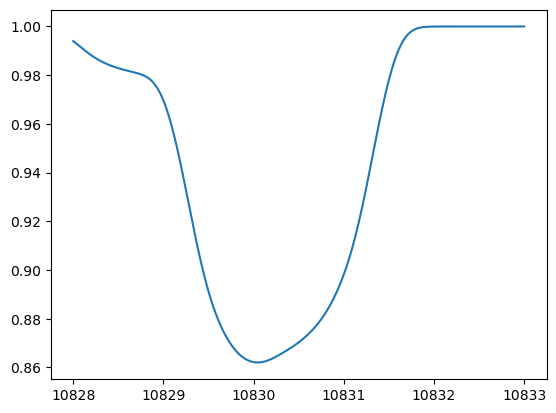

In [631]:
wavgrid = np.linspace(1.0828e-4, 1.0833e-4, 400) * 1e8
plt.plot(wavgrid, intensity)
#plt.plot(wavgrid, intensity2)

In [23]:
4.5e29 / ( 4 * np.pi * (0.02*1.5e13)**2) / 10**5

3.9788735772973842

In [74]:
#total disk mass

testTorus.get_height() * testTorus.nH * mp * np.pi * testTorus.D**2 / (1e12 * day)

3.9019359958721265

In [28]:
testTorus.calculate_ion_abundances_all_species()

In [29]:
testTorus.do_transit_He()

TypeError: must be real number, not tuple

In [11]:
testTorus.species_ion_abundances

{'h': array([0.027114, 0.972886]),
 'he': array([2.11108683e-02, 4.40128497e-06, 5.87481473e-01, 3.91403258e-01]),
 'mg': array([7.99016372e-02, 4.04140661e-01, 4.01640337e-01, 1.10201689e-01,
        4.07548167e-03, 4.01491408e-05, 4.57471148e-08, 8.34367788e-12,
        8.05560191e-16, 2.76548500e-20, 2.06586392e-25, 5.18934354e-34,
        1.02804907e-42]),
 'ca': array([ 1.86337216e-04,  1.35924345e-01,  4.75125695e-01,  3.60856726e-01,
         2.78428272e-02,  6.40525350e-05,  1.73101585e-08,  5.69489688e-12,
         5.19365152e-16,  9.45669491e-20,  4.97177361e-24,  1.14098887e-28,
         5.30316893e-34,  4.10834425e-39,  1.70093466e-44,  6.47491882e-54,
         1.21538972e-63,  1.76315428e-73,  3.12081692e-83, -0.00000000e+00,
        -0.00000000e+00]),
 'na': array([1.97172646e-05, 7.55568843e-02, 7.67235044e-01, 1.53353208e-01,
        3.82782437e-03, 7.31562585e-06, 6.32729386e-09, 8.29388545e-13,
        1.40666569e-17, 2.95640046e-22, 6.44936599e-31, 6.08212673e-40])}

In [48]:
testTorus.calculate_column_density('mg_2') / 10**14

0.859010445507405

In [49]:
testTorus.calculate_tau_species('mg_2')

(array([1.73994670e+02, 8.69469751e+01, 1.73223195e+00, 1.62556878e+00,
        1.55535092e+00, 1.67648500e+00, 8.19074480e-01, 3.97272335e-01,
        2.13903361e-01, 1.41725969e-01]),
 array([2.796350e-05, 2.803531e-05, 1.995180e-06, 1.995080e-06,
        1.998070e-06, 2.483900e-06, 2.472100e-06, 2.090930e-06,
        2.094290e-06, 1.885300e-06]))

In [13]:
#what do I want to compare:

#helium optical depth vs calcium h and k optical depth

#to show that it works:
#take a sample of stars with measured helium and H and K lines
#artificailly assume that some of them have a close in planet
#see if they can be distinguished 

In [61]:
1 / (4e-13 * (1e-17 / mp)) / day

4.832175925925926

In [60]:
yr = 365 * 24 * 60 * 60
day = 24 * 60 * 60 

In [54]:
testTorus.nH * mp

3.258825560430716e-17

In [67]:
(1 / (10**-3 * 10**-5)) / day

1157.4074074074074

In [417]:
def doppler_shift(w0, velocity):
    return (1 + velocity / c)*w0

def voigt_profile(w, w0, gauss_sigma, lorentz_HWHM):
    """Return

    Parameters
    --------------------
    w:

    w0:

    gauss_sigma: standard variation of

    lorentz_HWHM:

    """

    return sp_special.voigt_profile(w-w0, gauss_sigma, lorentz_HWHM)

    
def voigt_xsection(w, w0, f, Gamma, T, mmw):
    """
    Compute the absoprtion cross section using the voigt profile for a line

    Parameters
    ------------------------
    w:

    w0: Line center wavelength (may be doppler shifted)

    f:

    Gamma:

    T:

    mass:

    Returns
    --------------------------
    """

    lorentz_HWHM = Gamma / (4*np.pi)
    #fixed from last commit
    gauss_sigma = np.sqrt(k_b*T/(mmw * c**2))*w0
    xsection = np.pi * e**2 / (m_e * c) * f * voigt_profile(w, w0, gauss_sigma, lorentz_HWHM)
    return xsection


def He_triplet_xsection(w, absorber_v, T, j):
    if j == 0:
        absorber_w0 = doppler_shift(c / He_wavj0, absorber_v) #in the frame of the object emitting light
        f = 5.9902e-02
        Gamma = 1.0216e+07
    elif j == 1:
        absorber_w0 = doppler_shift(c / He_wavj1, absorber_v)
        f = 1.7974e-01
        Gamma = 1.0216e+07
    elif j == 2:
        absorber_w0 = doppler_shift(c / He_wavj2, absorber_v)
        f = 2.9958e-01
        Gamma = 1.0216e+07

    xsection = voigt_xsection(w, absorber_w0, f, Gamma, T, 4*m_p)
    return xsection

def He_triplet_xsection_atlc(T):
    return He_triplet_xsection(c /  1.083033e-4, 0, T, 2) 


class xsection():
    #class to extract cross sections from Chianti
    def __init__(self, species, species_base):
        self.species = species
        self.species_base = species_base

    def getZ(self):
        return Zelem_lc[self.species_base]

    def topN_xs(self, T, N = 10):
        #based off top N f values so may be not be exactly true
        ion = ch.ion(self.species, temperature = np.float64(T), eDensity = 1.0)
        lv1 = np.array(ion.Wgfa['lvl1'])
        lv2 = np.array(ion.Wgfa['lvl2'])
        wvl = np.array(ion.Wgfa['wvl'])
        gf = np.array(ion.Wgfa['gf'])
        A = np.array(ion.Wgfa['avalue'])

        mask = (lv1 == 1) & (wvl != 0.0)
        ind = np.argsort(gf[mask])[::-1]
        wvl1 = np.abs(wvl[mask][ind]) * 1e-8 #change wavelength from angstom to cgs
        w  = c / wvl1   
        gf1 = gf[mask][ind]
        A1 = A[mask][ind]
        

        if N < len(ind):
            return voigt_xsection(w[:N], w[:N], gf1[:N], A1[:N], T, 2 * self.getZ() * mp), wvl1[:N]
        else:
            return voigt_xsection(w, w, gf1, A1, T, 2 * self.getZ() * mp), wvl1

In [398]:
h1_xsection = xsection('h_1', 'h')
h1_xsection.topN_xs(10**4)

(array([1.11008138e-13, 5.56043507e-14, 1.77304056e-14, 8.89898369e-15,
        6.19671918e-15, 3.09035349e-15, 2.90856114e-15, 1.45428057e-15,
        0.00000000e+00]),
 array([1.215668e-05, 1.215674e-05, 1.025722e-05, 1.025723e-05,
        9.725370e-06, 9.725370e-06, 9.497430e-06, 9.497430e-06,
        1.215673e-05]))

In [270]:
mg2_xsection = xsection('mg_2', 'mg')
mg2_xsection.topN_xs(10**4)

(array([2.02552450e-12, 1.01217599e-12, 2.01654352e-14, 1.89237370e-14,
        1.81063098e-14, 1.95164682e-14, 9.53509336e-15, 4.62476722e-15,
        2.49011362e-15, 1.64987481e-15]),
 array([2.796350e-05, 2.803531e-05, 1.995180e-06, 1.995080e-06,
        1.998070e-06, 2.483900e-06, 2.472100e-06, 2.090930e-06,
        2.094290e-06, 1.885300e-06]))

In [683]:
#stellar spectrum 

star_sp = pd.read_csv('test.dat', delimiter = ',', skiprows = 1)

In [684]:
star_sp

,wl,F_wl,unc,nu,F_nu
0,5.000000e-09,1.405196e-02,77.214417,5.995849e+18,1.171807e-29
1,1.500000e-08,5.189303e+00,12.228290,1.998616e+18,3.894672e-26
2,2.500000e-08,2.402619e+01,3.204344,1.199170e+18,5.008921e-25
3,3.500000e-08,1.181141e+02,1.402067,8.565499e+17,4.826333e-24
4,4.500000e-08,5.690522e+02,0.811103,6.662055e+17,3.843762e-23
...,...,...,...,...,...
1895,1.895500e-05,3.594734e+07,0.014672,1.581601e+15,4.308177e-13
1896,1.896500e-05,3.705059e+07,0.013978,1.580767e+15,4.445086e-13
1897,1.897500e-05,3.522409e+07,0.016207,1.579934e+15,4.230411e-13
1898,1.898500e-05,3.087289e+07,0.015229,1.579102e+15,3.711743e-13


In [568]:
star_sp['nu'] * const.h * const.erg

0       24798.901798
1        8266.300599
2        4959.780360
3        3542.700257
4        2755.433533
            ...     
1895        6.541520
1896        6.538071
1897        6.534625
1898        6.531183
1899        6.527745
Name: nu, Length: 1900, dtype: float64

In [673]:
star_sp['F_nu']

0       1.171807e-29
1       3.894672e-26
2       5.008921e-25
3       4.826333e-24
4       3.843762e-23
            ...     
1895    4.308177e-13
1896    4.445086e-13
1897    4.230411e-13
1898    3.711743e-13
1899    4.097280e-13
Name: F_nu, Length: 1900, dtype: float64

In [7]:
MgI = at.atomic_species('Mg I')
phion_rate = np.abs(sp_int.trapezoid(star_sp['F_nu'] * MgI.cross_section(star_sp['nu'] * const.h * const.erg) / (const.h * star_sp['nu']), star_sp['nu']))

In [8]:
phion_rate

4.316042158435017e-07

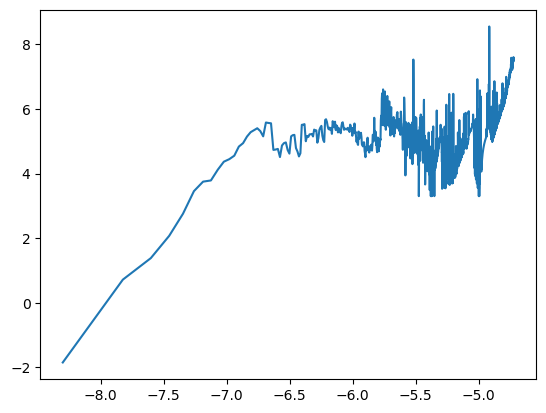

In [10]:
plt.plot(np.log10(star_sp['wl']), np.log10(star_sp['F_wl']))

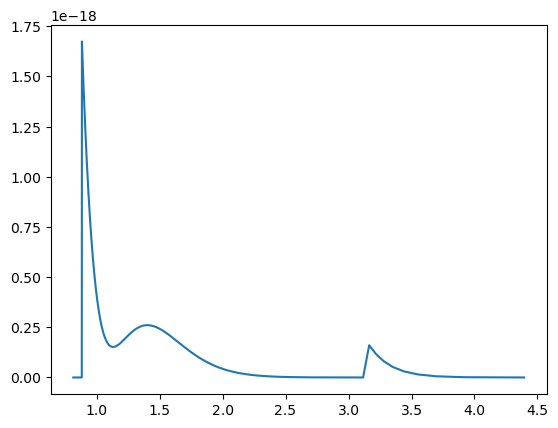

In [11]:
plt.plot(np.log10(star_sp['nu'] * const.h * const.erg), MgI.cross_section(star_sp['nu'] * const.h * const.erg))

In [12]:
def normalize_spectrum(stellar_spectrum, Feuv, euv_range = [1e-6, 1.17e-5]):

    normalized_stellar_spectrum = stellar_spectrum.copy(deep=True)
    euv_mask = (stellar_spectrum['wl'] > euv_range[0]) & (stellar_spectrum['wl'] > euv_range[1])
    Feuv_ss = sp_int.trapezoid(stellar_spectrum['F_wl'][euv_mask], stellar_spectrum['wl'][euv_mask])
    normalized_stellar_spectrum['F_wl'] *= (Feuv / Feuv_ss)
    normalized_stellar_spectrum['F_nu'] *= (Feuv / Feuv_ss)
    
    return normalized_stellar_spectrum

In [560]:
def get_phion_rates(species, stellar_spectrum):
    #species in chianti format (need to change to McAstro format)
    Z = Zelem_lc[species]
    phion_rates = np.zeros(Z, 'float64')

    F_nu, nu = stellar_spectrum['F_nu'], stellar_spectrum['nu']

    for i in range(Z):
        ion = at.atomic_species(species.capitalize() + ' ' + at.arabic_to_roman(i+1))
        phion_rate = np.abs(sp_int.trapezoid(F_nu * ion.cross_section(nu * const.h * const.erg) / (const.h * nu), nu))
        phion_rates[i] = phion_rate

    return phion_rates

In [561]:
def get_triplet_rate(stellar_spectrum):
    F_nu, nu = stellar_spectrum['F_nu'][::-1], stellar_spectrum['nu'][::-1]
    ss_intpl = sp_intpl.InterpolatedUnivariateSpline(nu, F_nu)
    data = pd.read_csv('HeMetastableData.csv', skiprows = 1)
    w = c / (data['wvl'].values * 1e-8)
    print(w)
    print(nu)
    print(data['wvl'])
    xs = sp_intpl.InterpolatedUnivariateSpline(w, data['sigma'].values * 8.067e-18)
    phion_rate = sp_int.quad(lambda nu : ss_intpl(nu) * xs(nu) / (const.h * nu), a = nu.values[0], b = nu.values[-1])
    return phion_rate[0]
    

[1.15614672e+15 1.18575152e+15 1.31732975e+15 1.48179819e+15
 1.81073066e+15 2.46860615e+15 3.12649264e+15 3.78436719e+15
 4.44225469e+15 5.10011738e+15 5.75799481e+15 6.41577675e+15
 7.07368868e+15 7.73152805e+15 9.04725978e+15 1.10241230e+16
 1.10537960e+16 1.16786132e+16 1.23365294e+16 1.29942352e+16
 1.36522610e+16 1.43104683e+16]
1899    1.578270e+15
1898    1.579102e+15
1897    1.579934e+15
1896    1.580767e+15
1895    1.581601e+15
            ...     
4       6.662055e+17
3       8.565499e+17
2       1.199170e+18
1       1.998616e+18
0       5.995849e+18
Name: nu, Length: 1900, dtype: float64
0     2593.01
1     2528.27
2     2275.74
3     2023.15
4     1655.63
5     1214.41
6      958.87
7      792.18
8      674.86
9      587.81
10     520.65
11     467.27
12     423.81
13     387.75
14     331.36
15     271.94
16     271.21
17     256.70
18     243.01
19     230.71
20     219.59
21     209.49
Name: wvl, dtype: float64


/var/folders/3z/jz_8jm5j13b896ydcgw7m65c0000gn/T/ipykernel_48477/3382805063.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  phion_rate = sp_int.quad(lambda nu : ss_intpl(nu) * xs(nu) / (const.h * nu), a = nu.values[0], b = nu.values[-1])


1.4385669700739966e-05

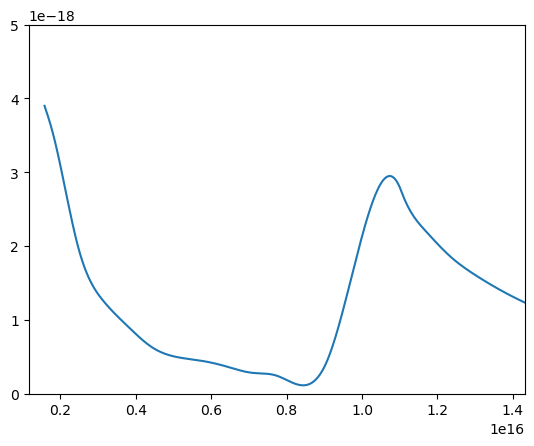

In [554]:
get_triplet_rate(star_sp)

array([8.89742871e-05, 9.96952166e-07, 8.21040172e-07, 4.26901725e-07,
       1.85706947e-07, 4.67846595e-08, 1.37821695e-08, 5.04569446e-09,
       1.19627884e-09, 4.81566563e-10, 4.42101553e-13, 1.05508886e-13])

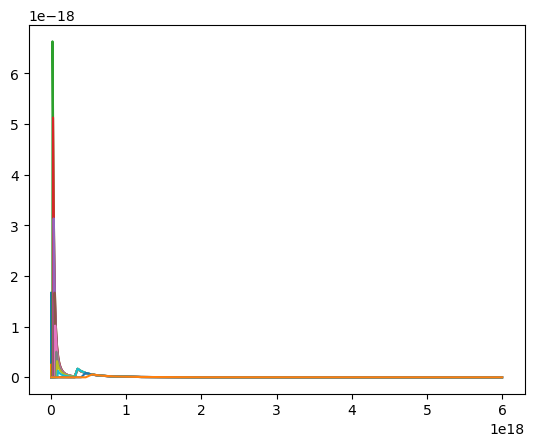

In [527]:
get_phion_rates('mg', sp)

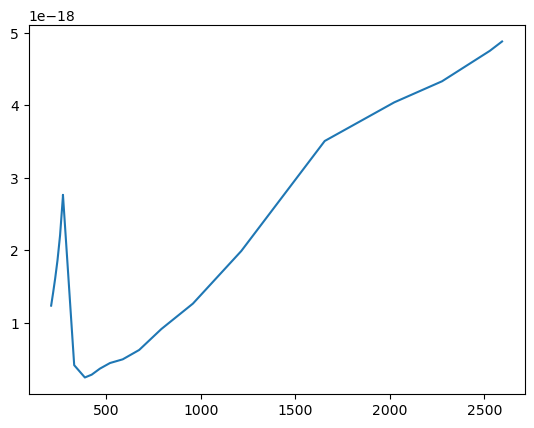

In [502]:
data = pd.read_csv('HeMetastableData.csv', skiprows = 1)
plt.plot(data['wvl'], data['sigma'] * 8.067e-18)

In [14]:
def get_rr_rates(species, T):

    #get atomic mass of species
    Z = Zelem_lc[species]
    rr_rates = np.zeros(Z, 'float64')

    #loop through chianti to get recombination rates
    for i in range(Z):
        ion = ch.ion(f'{species}_{i + 2}', temperature = T)
        ion.recombRate()
        rr_rates[i] = ion.RecombRate['rate'][0]

    return rr_rates

In [93]:
class PhESolver:
    #class to calculate 
    def __init__(self, species, stellar_spectrum, n_e):
        self.species = species #insert in chianti form
        self.stellar_spectrum = stellar_spectrum #if there's a stellar spectrum available
        self.n_e = n_e

    def getZ(self):
        return Zelem_lc[self.species]

    def calculate_abundances(self, T):
        Z = self.getZ()
        
        phi_rates = np.concatenate((get_phion_rates(self.species, self.stellar_spectrum), np.array([0.0])))
        rr_rates = get_rr_rates(self.species, np.float64(T))
        
        M = np.zeros((Z+1,Z+1))
        M[-1,:] = 1
        M += np.diag(phi_rates, 0) - np.diag(rr_rates, 1) * self.n_e
        
        o = np.zeros(Z+1)
        o[-1] = 1

        abundances = np.linalg.solve(M, o)

        return abundances

    #def plot_abundances(self, T)

In [70]:
class HPhESolver:
    #class to calculate number hydrogen and protons
    def __init__(self, stellar_spectrum, nH):
        self.stellar_spectrum = stellar_spectrum
        self.nH = nH

    def calculate_abundances(self, T):
        phi_rate = get_phion_rates('h', self.stellar_spectrum)[0]
        print(phi_rate)
        nHI = get_nHI(self.nH, phi_rate)
        nHII = get_ne(self.nH, phi_rate)
        return np.array([nHI, nHII]) / self.nH

In [555]:
class HePhESolver:
    #class to calculate number of helium atoms in them singlet, triplet, singly ionized and doubly ionized states
    def __init__(self, stellar_spectrum, nHI, ne):
        self.stellar_spectrum = stellar_spectrum
        self.nHI = nHI
        self.ne = ne


    def calculate_abundances(self, T):
        #constants (note these are at 10^4K)

        #electron/hydrogen collisional depopulation rates
        q13a = 4.5e-20 #cm^3s^-1
        q31a = 2.6e-8  #cm^3s^-1
        q31b = 4.0e-9  #cm^3s^-1
        Q31 = 5e-10    #cm^3s^-1
        A31 = 1.272e-4 #s^-1

        #photoionization rates
        phi1 = get_phion_rates('he', self.stellar_spectrum)[0]
        phi3 = get_phion_rates('he', self.stellar_spectrum)[0]
        phiHII = get_phion_rates('he', self.stellar_spectrum)[1]

        #recombination rates
        alpha1 = 2.16e-13  #use case A
        alpha3 = 2.25e-13  #check recombination values
        alphaHIII = get_rr_rates('he', np.float64(T))[1]

        M = np.zeros((4, 4))
        M[0, :] = np.array([-self.ne * alpha1 - phi1 - q13a * self.ne, -self.ne * alpha1 + A31 + q31a * self.ne + q31b * self.ne + Q31 * self.nHI, 0, -self.ne * alpha1])
        M[1, :] = np.array([-self.ne * alpha3 + q13a * self.ne, -self.ne * alpha1 - phi3 - A31 - q31a * self.ne - q31b * self.ne - Q31 * self.nHI, 0, -self.ne * alpha3])
        M[2, :] = np.array([0, 0, phiHII, - alphaHIII * self.ne])
        M[3, :] = np.ones(4)

        o = np.array([-self.ne * alpha1, -self.ne * alpha3, 0, 1])

        abundances = np.linalg.solve(M, o)

        return abundances   
    

In [556]:
alphaA_LyA = 4.18e-13
mp = 1.67e-24 #g
G = 6.67e-8
kb = 1.38e-16
xs_phot = 6.3e-18 

def get_nHI(nH, gamma):
    nHI = nH * (1 + (gamma - np.sqrt(gamma**2 + 4 * alphaA_LyA * nH * gamma)) / (2 * alphaA_LyA * nH))
    return nHI

def get_ne(nH, gamma):
    return nH - nHI(nH, gamma)

def get_tau_phot(nH, gamma, D):
    return nHI(nH, gamma) * xs_phot * D

def get_nH(tau, gamma, D):
    return tau / (D * xs_phot) + np.sqrt((tau * gamma) / (alphaA_LyA * D * xs_phot))

In [607]:
class Torus:
    def __init__(self, species, stellar_spectrum, Ms, ap, T, D, tau=0, nH=0):
        self.species = species #dictionary of species with abundances relative to hydrogen 
        self.species_ion_abundances = {} #dictionary of ion abundances to be filled in 
        self.stellar_spectrum = stellar_spectrum
        self.Ms = Ms
        self.ap = ap
        self.T = T
        self.D = D
        
        #on initialization, we calculate the hydrogen state abundances. In order to do this, we need either an number density of hydrogen or a optical depth 
        gamma = get_phion_rates('h', self.stellar_spectrum)[0]
        if tau:
            nH = get_nH(tau, gamma, self.D)
            self.tau = tau
            self.nH = nH
        elif nH:
            tau = get_tau_phot(nH, gamma, self.D)
            self.nH = nH
            self.tau = tau

        print(self.nH)
        Hspecies_solver = HPhESolver(self.stellar_spectrum, self.nH)
        Hion_abundances = Hspecies_solver.calculate_abundances(self.T)
        self.species_ion_abundances['h'] = Hion_abundances
        #done
            
        
    def get_height(self):
        cs = np.sqrt(2 * kb * self.T / mp)
        H = np.sqrt(2 * cs**2 * self.ap**3 / (G * self.Ms))
        return H
        
    def calculate_ion_abundances(self, single_species):

        if single_species in self.species_ion_abundances:
            return self.species_ion_abundances[single_species]
        elif single_species == 'he':
            he_species_solver = HePhESolver(self.stellar_spectrum, self.nH * self.species_ion_abundances['h'][0], self.nH * self.species_ion_abundances['h'][1])
            he_abundances = he_species_solver.calculate_abundances(self.T)
            self.species_ion_abundances[single_species] = he_abundances
            return he_abundances
        else:
            species_solver = PhESolver(single_species, self.stellar_spectrum, self.nH * self.species_ion_abundances['h'][1])
            ion_abundances = species_solver.calculate_abundances(self.T)
            self.species_ion_abundances[single_species] = ion_abundances
            return ion_abundances

    def calculate_ion_abundances_all_species(self):

        for sp in self.species:
            ion_abundances = self.calculate_ion_abundances(sp)
            self.species_ion_abundances[sp] = ion_abundances

    def calculate_column_density(self, species_state):
        if species_state == 'he_triplet':
            ncol = self.nH * self.species['he'] * self.species_ion_abundances['he'][1] * self.D
            return ncol
        species, ionic_state = species_state.partition('_')[0], int(species_state.partition('_')[2])
        if species in self.species_ion_abundances:
            ncol = self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state - 1] * self.D
            return ncol
        else:
            print("the ionic abundances for this species has not been calculated yet")
            
        

    def calculate_tau_species(self, species_state, nlines = 10):
        if species_state == 'he_triplet':
            tau = self.nH * self.species['he'] * self.species_ion_abundances['he'][1] * He_triplet_xsection_atlc(self.T) * self.D
            return tau
        species, ionic_state = species_state.partition('_')[0], int(species_state.partition('_')[2])
        if species in self.species_ion_abundances:
            species_xsection = xsection(species_state, species)
            xs, wvl = species_xsection.topN_xs(self.T, nlines)
            tau = self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state - 1] * xs * self.D
            return tau, wvl 
        else:
            print("the ionic abundances for this species has not been calculated yet")

In [75]:
sp = normalize_spectrum(star_sp, 10**4)
testTorus = Torus({'h':1, 'he' : 0.25, 'mg': abundance(7.56), 'ca' : abundance(6.32), 'na' : abundance(6.21)}, sp, 1e33, 0.02*1.5e13, 10**4, 0.02*1.5e13, tau = 1)
testTorus.calculate_ion_abundances('he')
testTorus.calculate_ion_abundances_all_species()



NameError: name 'star_sp' is not defined

In [609]:
testTorus.calculate_column_density('mg_2') / 1e17

0.00032524651138805935

In [624]:
t = testTorus.nH * testTorus.D * mp * 4 * np.pi * testTorus.ap**2 / 1e12
t / (60 * 60 * 24 * 365)

0.09897567848637552

In [625]:
(testTorus.nH * np.pi * testTorus.D**2 * testTorus.get_height() * mp) / (1e11 * 60 * 60 * 24 * 365)

0.030170152814668883

9.199441590556803e-18

In [613]:
2.79e-5 / 1e-8

2790.0

In [610]:
print(testTorus.calculate_tau_species('mg_2'))

(array([6.58794778e+01, 3.29206711e+01, 6.55873746e-01, 6.15487945e-01,
       5.88901408e-01, 6.34766318e-01, 3.10125585e-01, 1.50418940e-01,
       8.09900768e-02, 5.36616025e-02]), array([2.796350e-05, 2.803531e-05, 1.995180e-06, 1.995080e-06,
       1.998070e-06, 2.483900e-06, 2.472100e-06, 2.090930e-06,
       2.094290e-06, 1.885300e-06]))


In [563]:
print(testTorus.calculate_tau_species('mg_2'))
print(testTorus.calculate_tau_species('ca_2'))
print(testTorus.calculate_tau_species('na_2'))
print(testTorus.calculate_tau_species('he_1'))
print(testTorus.calculate_tau_species('h_1'))
print(testTorus.calculate_tau_species('he_triplet'))

[3.39657639e+01 1.69730511e+01 3.38151630e-01 3.17329750e-01
 3.03622416e-01 3.27269183e-01 1.59892773e-01 7.75521359e-02
 4.17564000e-02 2.76665417e-02]
[5.19042434e+00 2.59313919e+00 2.66086267e-03 2.00078665e-03
 1.54147625e-03 1.42621590e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[0.03979455 0.02861414 0.00912235 0.0082823  0.00818528 0.00662944
 0.00637535 0.00651525 0.00566137 0.00598542]
[2.38982835e+03 5.84715250e+02 2.33997308e+02 1.17061149e+02
 3.14200818e-04 0.00000000e+00]
[17620.33939553  8826.08740613  2814.3500987   1412.53709309
   983.60621965   490.53230075   461.67637126   230.83818563
     0.        ]
1.029847824730569


In [564]:
testTorus.calculate_ion_abundances('mg')[1] * testTorus.species['mg'] * testTorus.nH * Mg_resonance(c/2.795e-5, 0, 10**4) * 2e11

32.426805964411415

In [241]:
Mg_resonance(c/2.795e-5, 0, 10**4)

9.668749120744076e-13

In [280]:
'mg_2'.partition('_')[2]

'2'

In [184]:
testTorus.calculate_ion_abundances_all_species()

In [187]:
testTorus.species_ion_abundances['he']

array([7.79216038e-01, 1.58264728e-06, 2.19698057e-01, 1.08432244e-03])

In [102]:
c = 2.9979e10
m_e = 9.11e-28
m_p = 1.67e-24
e = 4.803e-10
k_b = 1.3807e-16
He_wavj0 = 1.082909e-4
He_wavj1 = 1.083025e-4
He_wavj2 = 1.083033e-4 #cm

def doppler_shift(w0, velocity):
    return (1 + velocity / c)*w0

def voigt_profile(w, w0, gauss_sigma, lorentz_HWHM):
    """Return

    Parameters
    --------------------
    w:

    w0:

    gauss_sigma: standard variation of

    lorentz_HWHM:

    """

    return sp_special.voigt_profile(w-w0, gauss_sigma, lorentz_HWHM)

def voigt_xsection(w, w0, f, Gamma, T, mmw):
    """
    Compute the absoprtion cross section using the voigt profile for a line

    Parameters
    ------------------------
    w:

    w0: Line center wavelength (may be doppler shifted)

    f:

    Gamma:

    T:

    mass:

    Returns
    --------------------------
    """

    lorentz_HWHM = Gamma / (4*np.pi)
    #fixed from last commit
    gauss_sigma = np.sqrt(k_b*T/(mmw * c**2))*w0
    xsection = np.pi * e**2 / (m_e * c) * f * voigt_profile(w, w0, gauss_sigma, lorentz_HWHM)
    return xsection

def He_triplet_xsection(w, absorber_v, T, j):
    if j == 0:
        absorber_w0 = doppler_shift(c / He_wavj0, absorber_v) #in the frame of the object emitting light
        f = 5.9902e-02
        Gamma = 1.0216e+07
    elif j == 1:
        absorber_w0 = doppler_shift(c / He_wavj1, absorber_v)
        f = 1.7974e-01
        Gamma = 1.0216e+07
    elif j == 2:
        absorber_w0 = doppler_shift(c / He_wavj2, absorber_v)
        f = 2.9958e-01
        Gamma = 1.0216e+07

    xsection = voigt_xsection(w, absorber_w0, f, Gamma, T, 4*m_p)
    return xsection

def Mg_resonance(w, absorber_v, T):

    Mg_wav = 2.795e-5
    absorber_w0 = doppler_shift(c / Mg_wav, absorber_v) #in the frame of the object emitting light
    f = 6.08e-1
    Gamma = 2.60e8
    xsection = voigt_xsection(w, absorber_w0, f, Gamma, T, 24*m_p)
    return xsection

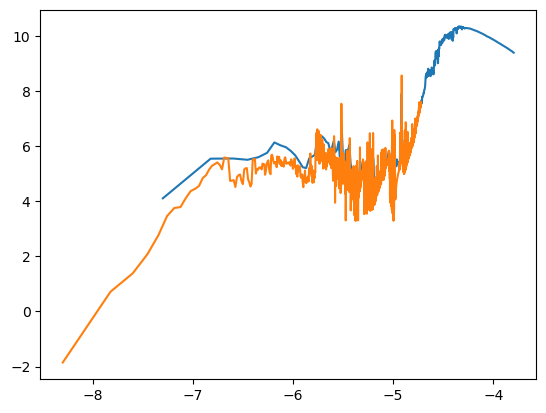

In [731]:
plt.plot(np.log10(ss['wav']), np.log10(ss['F_wav']))
plt.plot(np.log10(star_sp['wl']), np.log10(star_sp['F_wl']))
#plt.xlim(-8, -5)



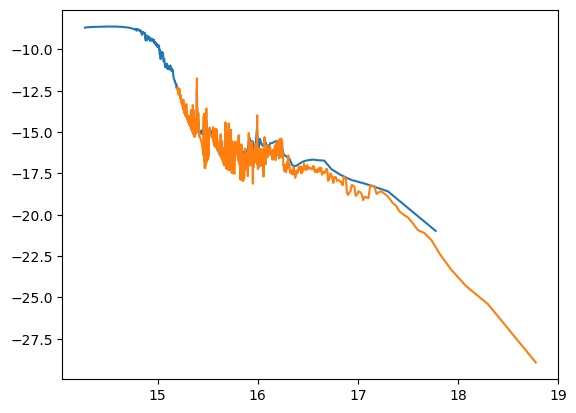

In [737]:
plt.plot(np.log10(ss['nu']), np.log10(ss['F_nu']))
plt.plot(np.log10(star_sp['nu']), np.log10(star_sp['F_nu']))

In [98]:
10216000 / 1e7

1.0216

In [32]:
for i in range(4):
    print((i>>1)&1)

0
0
1
1


In [30]:
for i in range(4):
    print((i>>2)&1)

0
0
0
0


In [13]:
ion.Elvlc

AttributeError: 'ion' object has no attribute 'Elvlc'

In [10]:
ion = ch.ion('mg_1', temperature = 10**4, eDensity = 1.0)
lv1 = np.array(ion.Wgfa['lvl1'])
lv2 = np.array(ion.Wgfa['lvl2'])
wvl = np.array(ion.Wgfa['wvl'])
gf = np.array(ion.Wgfa['gf'])
A = np.array(ion.Wgfa['avalue'])
term=np.array(ion.Elvlc['term'])
spin=np.array(ion.Elvlc['spin']) #spin multiplicity
j=np.array(ion.Elvlc['j'])
mult=np.array(ion.Elvlc['mult'])


mask = (lv1 == 3) & (wvl > 9e2)
ind = np.argsort(gf[mask])[::-1]
wvl1 = np.abs(wvl[mask][ind]) * 1e-8 #change wavelength from angstom to cgs
w  = c / wvl1   
gf1 = gf[mask][ind] #gf is number of degenerate quantum states x oscillaor strength
A1 = A[mask][ind]
lv1=lv1[mask][ind]
lv2=lv2[mask][ind]
ll=term[lv1-1]
ls=spin[lv1-1]
lj=j[lv1-1]
ul=term[lv2-1]
us=spin[lv2-1]
uj=j[lv2-1]
mult=mult[lv1-1]

AttributeError: 'ion' object has no attribute 'Wgfa'

In [24]:
print(ll)
print(lj)
print(ul)
print(uj)
print(mult)
print(gf1)
print(gf1/mult)
print(lv1)
print(wvl1)

['1s.2s' '1s.2s' '1s.2s' '1s.2s']
[0. 0. 0. 0.]
['1s.2p' '1s.3p' '1s.4p' '1s.5p']
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[0.377  0.152  0.0507 0.0221]
[0.377  0.152  0.0507 0.0221]
[3 3 3 3]
[2.058690e-04 5.017077e-05 3.965850e-05 3.614672e-05]


In [97]:
1150000 / 1e7

0.115

In [24]:
import csv

with open('../escape_lines.csv', 'a', newline='') as csvfile:
    writer=csv.writer(csvfile, delimiter=',')
    i=2
    writer.writerow(['h_1', 'h_g', wvl1[i], ll[i], ls[i], lj[i], ul[i], us[i], uj[i], gf1[i]/mult[i], A1[i]])

In [8]:
g = draw.star(10)

In [9]:
g.intensity

array([[0.        , 0.        , 0.        , 0.01149425, 0.01149425,
        0.01149425, 0.01149425, 0.01149425, 0.        , 0.        ],
       [0.        , 0.        , 0.01149425, 0.01149425, 0.01149425,
        0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.        ],
       [0.        , 0.01149425, 0.01149425, 0.01149425, 0.01149425,
        0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.01149425],
       [0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.01149425,
        0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.01149425],
       [0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.01149425,
        0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.01149425],
       [0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.01149425,
        0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.01149425],
       [0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.01149425,
        0.01149425, 0.01149425, 0.01149425, 0.01149425, 0.01149425],
       [0.01149425, 0.01149425, 0.0114942

In [36]:
coords_x(``numpy.array``):
         Array of x coords

In [20]:
#make a datafile of recombination rates since calling from chianti is slow

with h5py.File('recombination_rates.h5', 'a') as f:
    for species, Z in Zelem_lc.items():
        f.create_dataset(species, (Z,), dtype=np.float64)
        for i in range(Z):
            ion = ch.ion(f'{species}_{i + 2}', temperature = T)
            ion.recombRate()
            species[i] = ion.RecombRate['rate'][0]    

h 1
he 2
li 3
be 4
b 5
c 6
n 7
o 8
f 9
ne 10
na 11
mg 12
al 13
si 14
s 16
ar 18
ca 20
fe 26


In [43]:
grid_size = 50
star_grid = draw.star(grid_size)
star_z = np.linspace(-WASP12.Rs, WASP12.Rs, grid_size)
star_y = np.linspace(-WASP12.Rs, WASP12.Rs, grid_size)

#xgrid extends out towards observer
Rin_grid = WASP12.Rtorus[0]*np.sin(WASP12.i) - WASP12.get_H()*np.cos(WASP12.i)
Rout_grid = WASP12.Rtorus[1]*np.sin(WASP12.i) + WASP12.get_H()*np.cos(WASP12.i)
xgrid = np.linspace(0.9*Rin_grid, 1.1*Rout_grid, 50)  
dx = xgrid[1] - xgrid[0]

#wavgrid
wavgrid = np.linspace(2.7958e-5, 2.7970e-5, 1000)
wgrid = const.c / wavgrid

#3D coordinate grid in observer frame
star_z = np.linspace(-WASP12.Rs, WASP12.Rs, grid_size)
xx, yy, zz = np.meshgrid(xgrid, star_y, star_z, indexing = 'ij')

#coordinates in orbital plane of disk 
yy_p = yy
zz_p = xx * np.cos(WASP12.i) + zz * np.sin(WASP12.i)
xx_p = xx * np.sin(WASP12.i) - zz * np.cos(WASP12.i)

#cylindrical r coordinate
R_p = np.sqrt(yy_p**2 + xx_p**2)

#los velocity in observer frame
ux = WASP12.omega_k(R_p) * yy_p * np.sin(WASP12.i)

#evaluation grid
dtau_eval_grid = np.tile(np.where(star_grid.intensity > 0, 1, 0), (np.shape(xgrid)[0], 1, 1))
dtau_eval_grid = np.where(np.abs(zz_p) < WASP12.get_H(), dtau_eval_grid, 0) #outside vertical extent of disk
dtau_eval_grid = np.where((R_p > WASP12.Rtorus[0]) & (R_p < WASP12.Rtorus[1]), dtau_eval_grid, 0) #outside disk radial
dtau_eval_grid = np.tile(np.expand_dims(dtau_eval_grid, axis=-1), len(wgrid)).astype(bool)

xs = xsection('mg_2', 'mg')
#
dtau_grid = self.nH * self.species[species] * self.species_ion_abundances[species][ionic_state-1] * xs.get_xs_lines(['mg2_h'], wgrid, np.expand_dims(ux, axis=-1), 10**4, where=dtau_eval_grid, out=np.zeros((50, 10, 10, 1000)))

tau = np.sum(dtau_grid, axis = 0)

I = np.einsum('ij, ijk->k', star_grid.intensity, np.exp(-tau))

array([[-1],
       [ 0]])